In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('last_version.csv')

In [3]:
df = df.sort_values(by='CAL_DT').reset_index(drop=True)
df.CAL_DT.unique()

array(['2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
       '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
       '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
       '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
       '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
       '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31'],
      dtype=object)

In [4]:
df['CAL_DT'] = pd.to_datetime(df['CAL_DT'])
df_monthly = df.groupby('CAL_DT')['DEVICE_COUNT'].sum().to_frame()
df_monthly = df_monthly.sort_index()

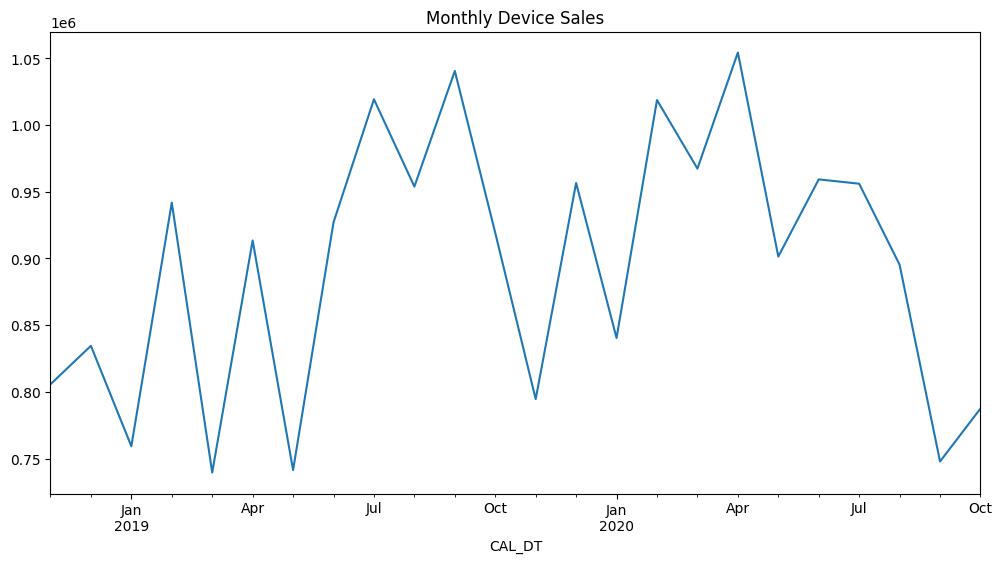

In [5]:
import matplotlib.pyplot as plt

df_monthly['DEVICE_COUNT'].plot(figsize=(12,6), title='Monthly Device Sales')
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_monthly['DEVICE_COUNT'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.9692462255541943
p-value: 0.30021817205712875


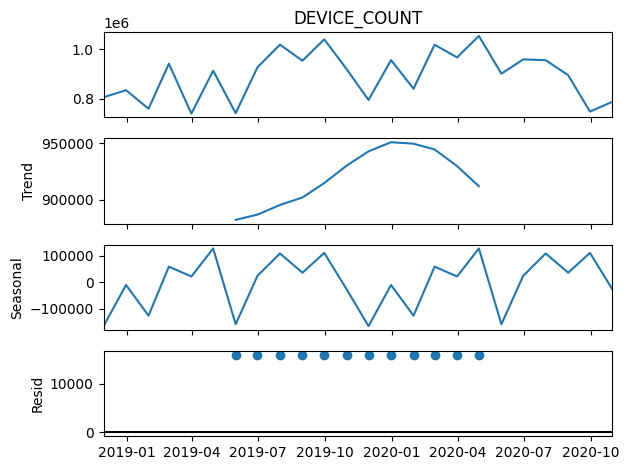

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_monthly['DEVICE_COUNT'], model='additive')
decomposition.plot()
plt.show()

In [8]:
import pmdarima as pm

model = pm.auto_arima(df_monthly['DEVICE_COUNT'], 
                      seasonal=True, m=12,   # monthly seasonality
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True)
print(model.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
n_periods = 12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

import numpy as np
index_of_fc = pd.date_range(df_monthly.index[-1] + pd.offsets.MonthEnd(1), periods=n_periods, freq='M')

# Create forecast series and confidence intervals
fc_series = pd.Series(forecast, index=index_of_fc)
lower_series = pd.Series(conf_int[:, 0], index=index_of_fc)
upper_series = pd.Series(conf_int[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_monthly['DEVICE_COUNT'], label='historical')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Device Count Forecast')
plt.legend()
plt.show()
